# Apollo CFD Database Exploration

This notebook explores the Apollo CFD database for re-entry analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette('husl')


In [2]:
# Load the Apollo CFD database
df = pd.read_csv('../Data/raw/apollo_cfd_database.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())


Dataset shape: (9282560, 15)

Column names:
['X', 'Y', 'Z', 'pw (Pa)', 'qw (W/m^2)', 'Me', 'delta (m)', 'theta (m)', 'Re-theta', 'tauw (Pa)', 'mach (-)', 'velocity (m/s)', 'density (kg/m^3)', 'aoa (degrees)', 'dynamic_pressure (Pa)']


In [3]:
df.head()

,X,Y,Z,pw (Pa),qw (W/m^2),Me,delta (m),theta (m),Re-theta,tauw (Pa),mach (-),velocity (m/s),density (kg/m^3),aoa (degrees),dynamic_pressure (Pa)
0,0.017768,0.003489,-0.407755,64489.349983,497625.036467,0.454910,0.006833,0.000982,188.672182,39.628433,14.16745,4500.0,0.003851,154.0,38991.469837
1,0.018617,0.007022,-0.417330,64611.153940,498418.814300,0.451899,0.006820,0.000980,187.407496,39.410061,14.16745,4500.0,0.003851,154.0,38991.469837
2,0.015687,0.003484,-0.383248,64163.104160,495351.845000,0.462855,0.006867,0.000986,192.028006,40.138121,14.16745,4500.0,0.003851,154.0,38991.469837
3,0.016301,0.006972,-0.390625,64263.850973,496055.340900,0.460389,0.006857,0.000985,190.994027,39.990073,14.16745,4500.0,0.003851,154.0,38991.469837
4,0.014133,0.003485,-0.363827,63903.617037,493426.773433,0.469249,0.006893,0.000989,194.737028,40.464771,14.16745,4500.0,0.003851,154.0,38991.469837


In [4]:
# Define input and output variables based on research context (for reference)
input_vars = ['velocity (m/s)', 'density (kg/m^3)', 'aoa (degrees)', 'dynamic_pressure (Pa)']
output_vars = ['qw (W/m^2)', 'pw (Pa)', 'tauw (Pa)', 'delta (m)', 'Me', 'Re-theta']

print("INPUT VARIABLES (Features for ML models):")
for var in input_vars:
    if var in df.columns:
        print(f"✓ {var}")
    else:
        print(f"✗ {var} - NOT FOUND")

print("\nOUTPUT VARIABLES (Targets for ML models):")
for var in output_vars:
    if var in df.columns:
        print(f"✓ {var}")
    else:
        print(f"✗ {var} - NOT FOUND")

# Basic statistics for key variables
print(f"\nDataset contains {df.shape[0]:,} CFD solution points")
print(f"This represents the 185 high-fidelity CFD solutions from Apollo 4 trajectory")


INPUT VARIABLES (Features for ML models):
✓ velocity (m/s)
✓ density (kg/m^3)
✓ aoa (degrees)
✓ dynamic_pressure (Pa)

OUTPUT VARIABLES (Targets for ML models):
✓ qw (W/m^2)
✓ pw (Pa)
✓ tauw (Pa)
✓ delta (m)
✓ Me
✓ Re-theta

Dataset contains 9,282,560 CFD solution points
This represents the 185 high-fidelity CFD solutions from Apollo 4 trajectory


In [5]:
# Analyze Apollo 4 trajectory conditions
print("\nVelocity Analysis:")
vel_stats = df['velocity (m/s)'].describe()
print(f"Velocity range: {vel_stats['min']/1000:.1f} - {vel_stats['max']/1000:.1f} km/s")
print(f"Mean velocity: {vel_stats['mean']/1000:.1f} km/s")

print("\nDensity Analysis:")
density_stats = df['density (kg/m^3)'].describe()
print(f"Density range: {density_stats['min']:.2e} - {density_stats['max']:.2e} kg/m³")
print(f"Span of {density_stats['max']/density_stats['min']:.1e}x - typical for reentry altitude variation")

print("\nAngle of Attack Analysis:")
aoa_stats = df['aoa (degrees)'].describe()
print(f"AoA range: {aoa_stats['min']:.1f}° - {aoa_stats['max']:.1f}°")
print(f"Number of unique AoA values: {df['aoa (degrees)'].nunique()}")

print("\nDynamic Pressure Analysis:")
q_stats = df['dynamic_pressure (Pa)'].describe()
print(f"Dynamic pressure range: {q_stats['min']:.1e} - {q_stats['max']:.1e} Pa")
print(f"Span of {q_stats['max']/q_stats['min']:.1e}x")



Velocity Analysis:
Velocity range: 3.0 - 11.0 km/s
Mean velocity: 7.0 km/s

Density Analysis:
Density range: 1.57e-05 - 8.21e-03 kg/m³
Span of 5.2e+02x - typical for reentry altitude variation

Angle of Attack Analysis:
AoA range: 152.0° - 158.0°
Number of unique AoA values: 4

Dynamic Pressure Analysis:
Dynamic pressure range: 3.3e+02 - 5.0e+04 Pa
Span of 1.5e+02x


In [6]:
# Critical analysis: Heat flux and pressure (primary targets per paper)

# Heat flux analysis
print("\nHeat Flux (qw) - Critical for TPS Design:")
qw_stats = df['qw (W/m^2)'].describe()
print(f"Range: {qw_stats['min']:.1e} - {qw_stats['max']:.1e} W/m²")
print(f"Mean: {qw_stats['mean']:.1e} W/m²")
print(f"Span: {qw_stats['max']/qw_stats['min']:.1e}x")

# Check for extreme values (stagnation point heating)
high_qw = df[df['qw (W/m^2)'] > qw_stats['75%'] * 2]
print(f"Extreme heat flux points (>2x 75th percentile): {len(high_qw):,} points")
print(f"Max heat flux likely at stagnation point: {qw_stats['max']:.2e} W/m²")

# Pressure analysis  
print("\nPressure (pw) - Also primary target:")
pw_stats = df['pw (Pa)'].describe()
print(f"Range: {pw_stats['min']:.1e} - {pw_stats['max']:.1e} Pa")
print(f"Mean: {pw_stats['mean']:.1e} Pa")
print(f"Span: {pw_stats['max']/pw_stats['min']:.1e}x")

# NASA baseline achieves ±5% accuracy for these - our ML goal
print(f"\n🎯 ML TARGET: Beat NASA's ±5% accuracy for heat flux & pressure")
print(f"   Heat flux ±5% range: ±{qw_stats['mean']*0.05:.1e} W/m²")
print(f"   Pressure ±5% range: ±{pw_stats['mean']*0.05:.1e} Pa")



Heat Flux (qw) - Critical for TPS Design:
Range: 1.5e+03 - 6.4e+06 W/m²
Mean: 6.3e+05 W/m²
Span: 4.3e+03x
Extreme heat flux points (>2x 75th percentile): 758,844 points
Max heat flux likely at stagnation point: 6.40e+06 W/m²

Pressure (pw) - Also primary target:
Range: 1.0e+00 - 9.6e+04 Pa
Mean: 1.3e+04 Pa
Span: 9.3e+04x

🎯 ML TARGET: Beat NASA's ±5% accuracy for heat flux & pressure
   Heat flux ±5% range: ±3.1e+04 W/m²
   Pressure ±5% range: ±6.7e+02 Pa


In [7]:
# Analyze challenging variables (shear stress, boundary layer, Re-theta)

# Shear stress analysis
print("\nShear Stress (tauw) - Sensitive to resolution:")
tau_stats = df['tauw (Pa)'].describe()
print(f"Range: {tau_stats['min']:.1e} - {tau_stats['max']:.1e} Pa")
print(f"Mean: {tau_stats['mean']:.1e} Pa")
print(f"Coefficient of variation: {(tau_stats['std']/tau_stats['mean']):.2f}")

# Boundary layer thickness
print("\nBoundary Layer Thickness (δ) - Complex physics:")
delta_stats = df['delta (m)'].describe()
print(f"Range: {delta_stats['min']:.1e} - {delta_stats['max']:.1e} m")
print(f"Mean: {delta_stats['mean']:.1e} m")
print(f"Span: {delta_stats['max']/delta_stats['min']:.1e}x")

# Momentum thickness Reynolds number - problematic per paper
print("\nMomentum Thickness Re (Re-theta) - Paper notes 'huge errors':")
re_theta_stats = df['Re-theta'].describe()
print(f"Range: {re_theta_stats['min']:.1e} - {re_theta_stats['max']:.1e}")
print(f"Mean: {re_theta_stats['mean']:.1e}")
print(f"Span: {re_theta_stats['max']/re_theta_stats['min']:.1e}x")

# Check for problematic near-zero values
near_zero_re = df[df['Re-theta'] < re_theta_stats['25%'] * 0.1]
print(f"Very low Re-theta values: {len(near_zero_re):,} points")
print(f"These likely represent stagnation/shoulder regions with interpolation issues")

print(f"\n💡 ML OPPORTUNITY: Stabilize Re-theta predictions, improve shear stress & δ accuracy")



Shear Stress (tauw) - Sensitive to resolution:
Range: 5.9e-02 - 4.0e+02 Pa
Mean: 4.9e+01 Pa
Coefficient of variation: 0.94

Boundary Layer Thickness (δ) - Complex physics:
Range: 2.3e-03 - 9.2e-01 m
Mean: 3.6e-02 m
Span: 4.1e+02x

Momentum Thickness Re (Re-theta) - Paper notes 'huge errors':
Range: 1.2e-07 - 5.4e+02
Mean: 1.1e+02
Span: 4.5e+09x
Very low Re-theta values: 204,525 points
These likely represent stagnation/shoulder regions with interpolation issues

💡 ML OPPORTUNITY: Stabilize Re-theta predictions, improve shear stress & δ accuracy


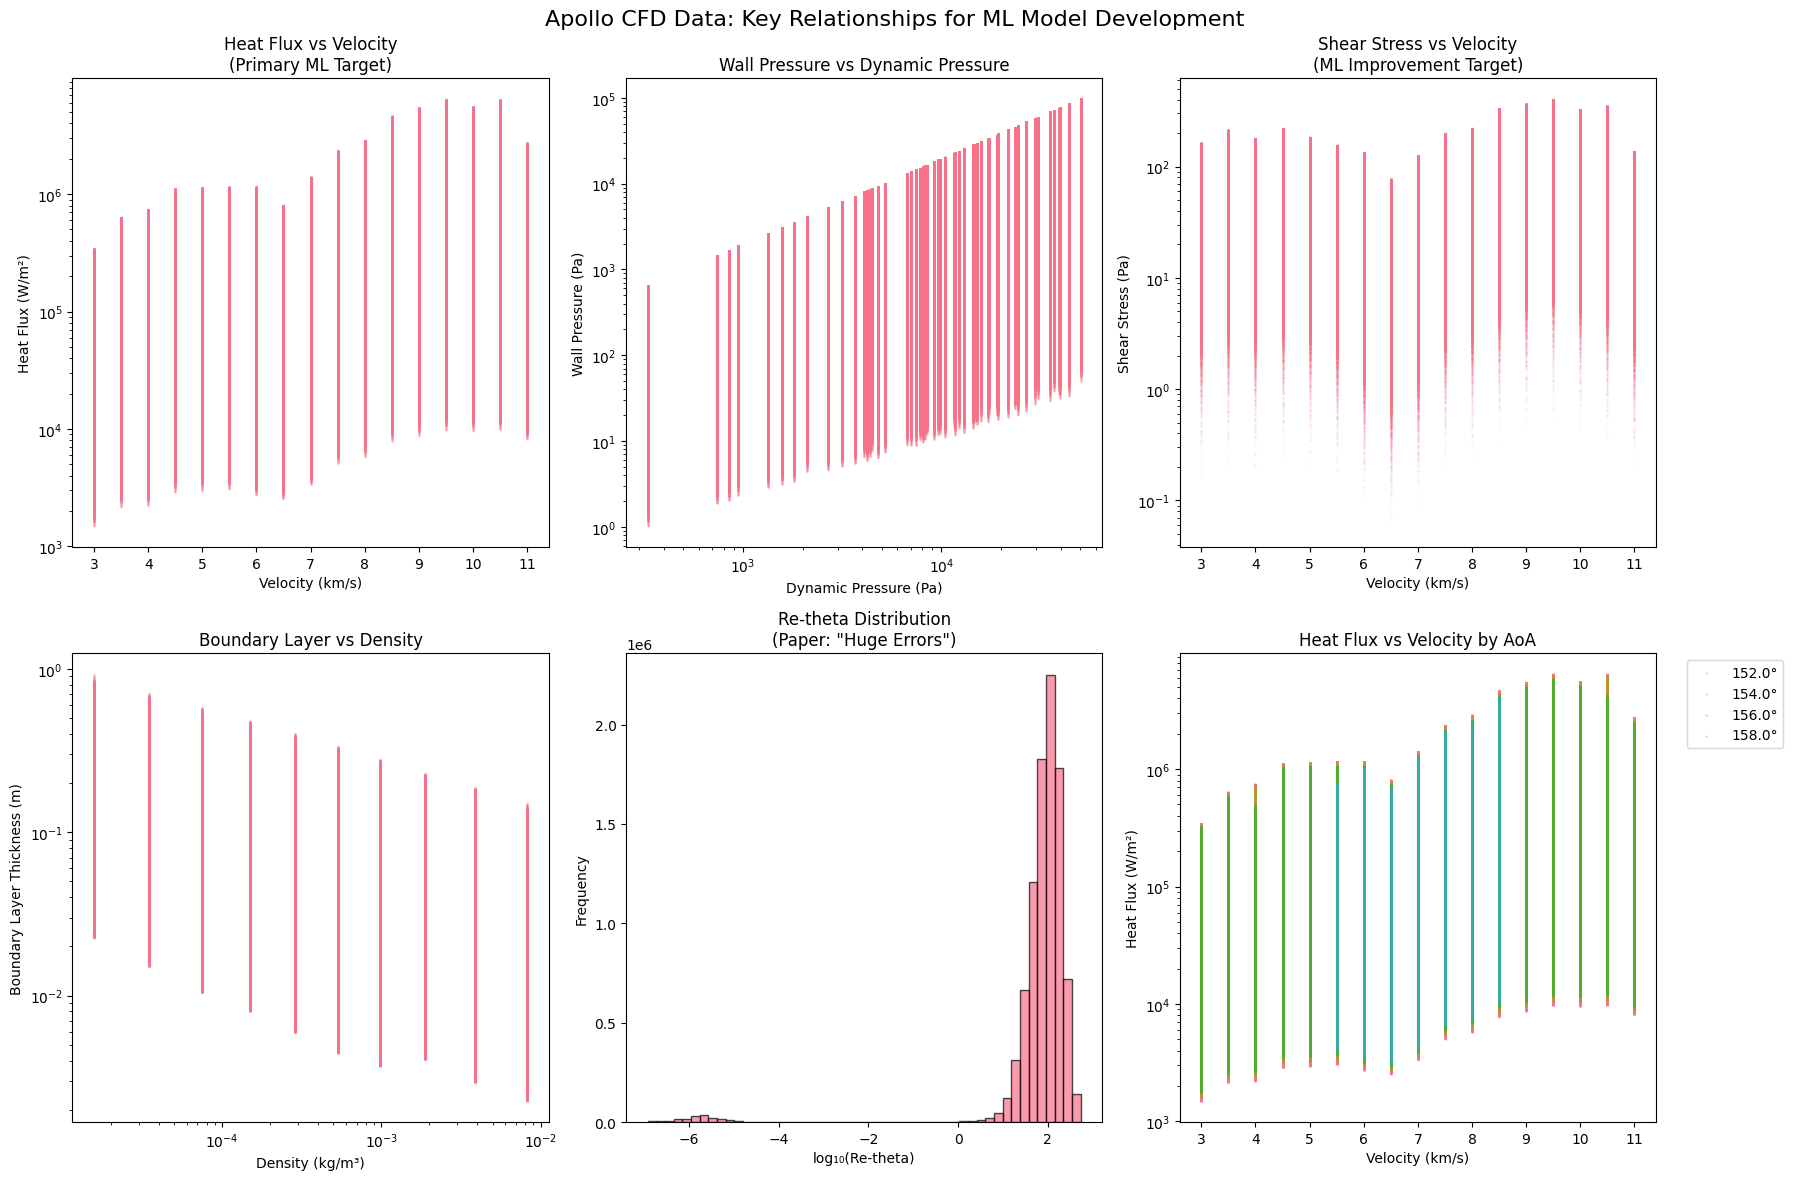

In [8]:
# Visualize key relationships for ML model design
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Apollo CFD Data: Key Relationships for ML Model Development', fontsize=16)

# 1. Heat flux vs velocity (primary relationship)
axes[0,0].scatter(df['velocity (m/s)']/1000, df['qw (W/m^2)'], alpha=0.1, s=0.1)
axes[0,0].set_xlabel('Velocity (km/s)')
axes[0,0].set_ylabel('Heat Flux (W/m²)')
axes[0,0].set_title('Heat Flux vs Velocity\n(Primary ML Target)')
axes[0,0].set_yscale('log')

# 2. Pressure vs dynamic pressure
axes[0,1].scatter(df['dynamic_pressure (Pa)'], df['pw (Pa)'], alpha=0.1, s=0.1)
axes[0,1].set_xlabel('Dynamic Pressure (Pa)')
axes[0,1].set_ylabel('Wall Pressure (Pa)')
axes[0,1].set_title('Wall Pressure vs Dynamic Pressure')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')

# 3. Shear stress vs velocity (challenging variable)
axes[0,2].scatter(df['velocity (m/s)']/1000, df['tauw (Pa)'], alpha=0.1, s=0.1)
axes[0,2].set_xlabel('Velocity (km/s)')
axes[0,2].set_ylabel('Shear Stress (Pa)')
axes[0,2].set_title('Shear Stress vs Velocity\n(ML Improvement Target)')
axes[0,2].set_yscale('log')

# 4. Boundary layer thickness vs density (complex physics)
axes[1,0].scatter(df['density (kg/m^3)'], df['delta (m)'], alpha=0.1, s=0.1)
axes[1,0].set_xlabel('Density (kg/m³)')
axes[1,0].set_ylabel('Boundary Layer Thickness (m)')
axes[1,0].set_title('Boundary Layer vs Density')
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')

# 5. Re-theta distribution (problematic variable)
axes[1,1].hist(np.log10(df['Re-theta']), bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('log₁₀(Re-theta)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Re-theta Distribution\n(Paper: "Huge Errors")')

# 6. AoA effect on heat flux
for aoa in sorted(df['aoa (degrees)'].unique()):
    subset = df[df['aoa (degrees)'] == aoa]
    axes[1,2].scatter(subset['velocity (m/s)']/1000, subset['qw (W/m^2)'], 
                     alpha=0.3, s=0.5, label=f'{aoa}°')
axes[1,2].set_xlabel('Velocity (km/s)')
axes[1,2].set_ylabel('Heat Flux (W/m²)')
axes[1,2].set_title('Heat Flux vs Velocity by AoA')
axes[1,2].set_yscale('log')
axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


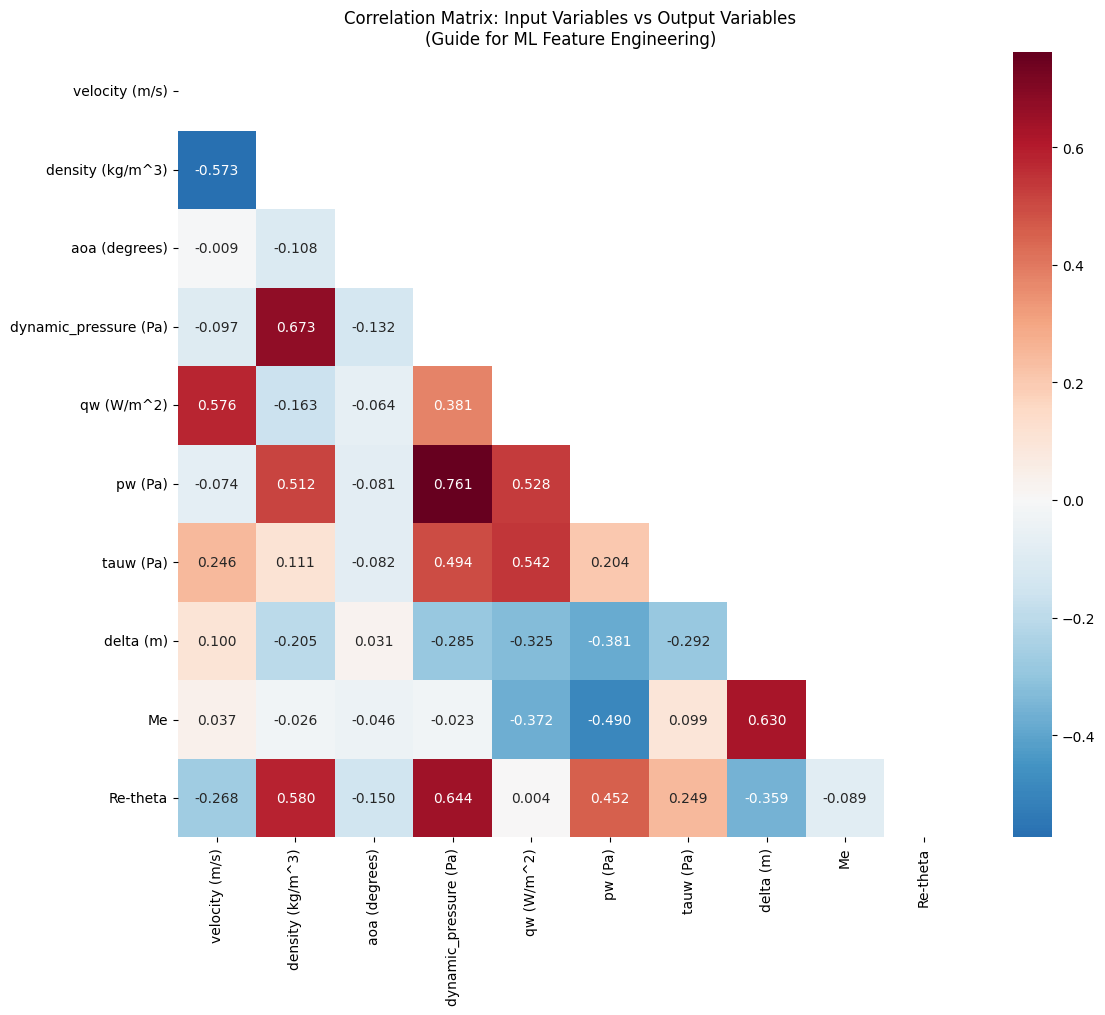


Key Input-Output Correlations (|r| > 0.5):

qw (W/m^2):
  velocity (m/s): 0.576

pw (Pa):
  density (kg/m^3): 0.512
  dynamic_pressure (Pa): 0.761

tauw (Pa):

delta (m):

Me:

Re-theta:
  density (kg/m^3): 0.580
  dynamic_pressure (Pa): 0.644


In [9]:
# Correlation analysis for ML feature engineering insights

# Focus on input-output correlations
ml_vars = input_vars + output_vars
ml_df = df[ml_vars].copy()

# Calculate correlation matrix
corr_matrix = ml_df.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, mask=mask, fmt='.3f')
plt.title('Correlation Matrix: Input Variables vs Output Variables\n(Guide for ML Feature Engineering)')
plt.tight_layout()
plt.show()

# Analyze key correlations
print("\nKey Input-Output Correlations (|r| > 0.5):")
for output in output_vars:
    print(f"\n{output}:")
    for input_var in input_vars:
        corr_val = corr_matrix.loc[output, input_var]
        if abs(corr_val) > 0.5:
            print(f"  {input_var}: {corr_val:.3f}")


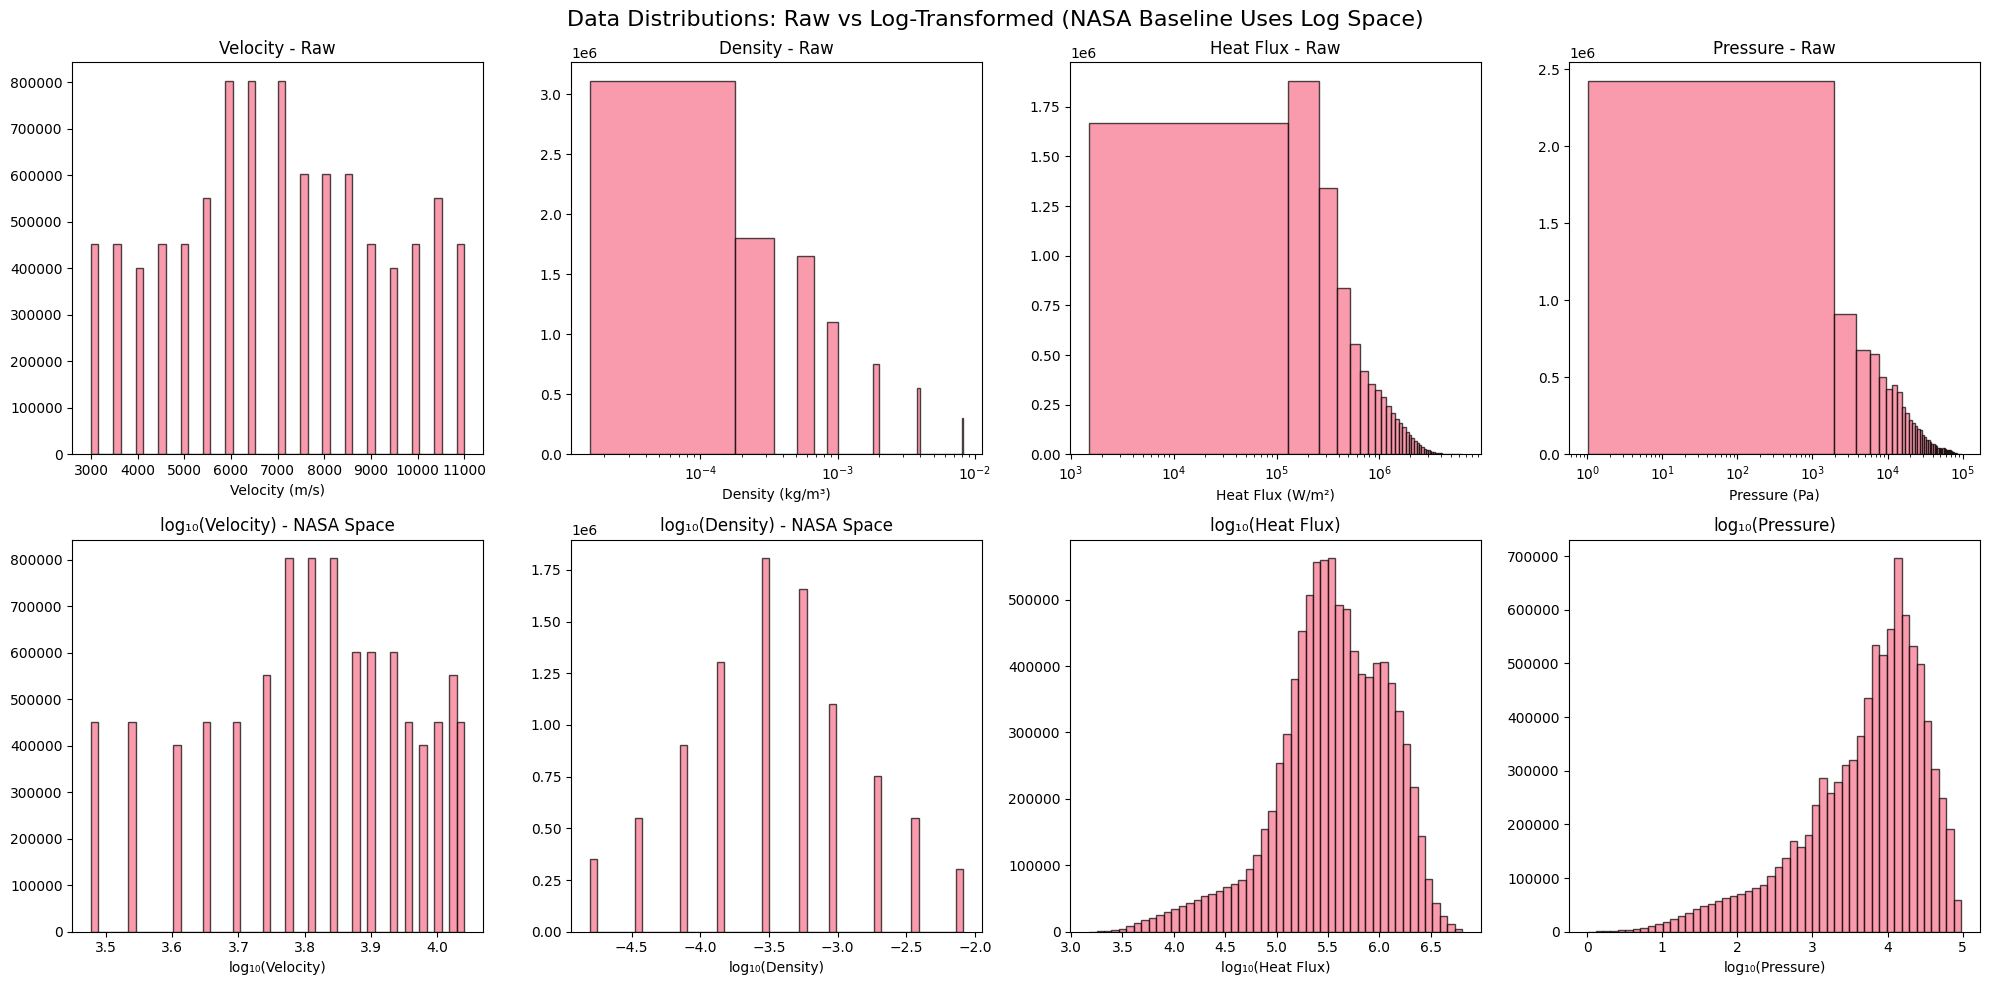


Normality Tests (Shapiro-Wilk p-values, sample of 5000 points):
velocity (m/s):
  Raw data p-value: 5.35e-33 (Non-normal)
  Log-transformed p-value: 1.69e-40 (Non-normal)
density (kg/m^3):
  Raw data p-value: 7.96e-78 (Non-normal)
  Log-transformed p-value: 1.05e-29 (Non-normal)
qw (W/m^2):
  Raw data p-value: 1.17e-64 (Non-normal)
  Log-transformed p-value: 2.04e-30 (Non-normal)
pw (Pa):
  Raw data p-value: 3.48e-64 (Non-normal)
  Log-transformed p-value: 1.76e-44 (Non-normal)


In [10]:
# Analyze data distribution for ML model selection insights

# Test log transformations as suggested by paper
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Data Distributions: Raw vs Log-Transformed (NASA Baseline Uses Log Space)', fontsize=16)

# Raw distributions
axes[0,0].hist(df['velocity (m/s)'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Velocity - Raw')
axes[0,0].set_xlabel('Velocity (m/s)')

axes[0,1].hist(df['density (kg/m^3)'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Density - Raw')
axes[0,1].set_xlabel('Density (kg/m³)')
axes[0,1].set_xscale('log')

axes[0,2].hist(df['qw (W/m^2)'], bins=50, alpha=0.7, edgecolor='black')
axes[0,2].set_title('Heat Flux - Raw')
axes[0,2].set_xlabel('Heat Flux (W/m²)')
axes[0,2].set_xscale('log')

axes[0,3].hist(df['pw (Pa)'], bins=50, alpha=0.7, edgecolor='black')
axes[0,3].set_title('Pressure - Raw')
axes[0,3].set_xlabel('Pressure (Pa)')
axes[0,3].set_xscale('log')

# Log-transformed distributions (NASA's successful approach)
axes[1,0].hist(np.log10(df['velocity (m/s)']), bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_title('log₁₀(Velocity) - NASA Space')
axes[1,0].set_xlabel('log₁₀(Velocity)')

axes[1,1].hist(np.log10(df['density (kg/m^3)']), bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_title('log₁₀(Density) - NASA Space')
axes[1,1].set_xlabel('log₁₀(Density)')

axes[1,2].hist(np.log10(df['qw (W/m^2)']), bins=50, alpha=0.7, edgecolor='black')
axes[1,2].set_title('log₁₀(Heat Flux)')
axes[1,2].set_xlabel('log₁₀(Heat Flux)')

axes[1,3].hist(np.log10(df['pw (Pa)']), bins=50, alpha=0.7, edgecolor='black')
axes[1,3].set_title('log₁₀(Pressure)')
axes[1,3].set_xlabel('log₁₀(Pressure)')

plt.tight_layout()
plt.show()

# Check for normality in log space (important for some ML algorithms)
from scipy import stats

print("\nNormality Tests (Shapiro-Wilk p-values, sample of 5000 points):")
sample_size = min(5000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

variables_to_test = ['velocity (m/s)', 'density (kg/m^3)', 'qw (W/m^2)', 'pw (Pa)']
for var in variables_to_test:
    # Test raw data
    _, p_raw = stats.shapiro(sample_df[var])
    # Test log-transformed data  
    _, p_log = stats.shapiro(np.log10(sample_df[var]))
    print(f"{var}:")
    print(f"  Raw data p-value: {p_raw:.2e} ({'Normal' if p_raw > 0.05 else 'Non-normal'})")
    print(f"  Log-transformed p-value: {p_log:.2e} ({'Normal' if p_log > 0.05 else 'Non-normal'})")


In [11]:
print("theta (m) stats:")
print(df['theta (m)'].describe())
print("\nRe-theta stats:")  
print(df['Re-theta'].describe())

theta (m) stats:
count    9.282560e+06
mean     3.332926e-03
std      3.990654e-01
min     -6.926536e+02
25%      1.669446e-03
50%      2.756707e-03
75%      4.598927e-03
max      2.417050e-02
Name: theta (m), dtype: float64

Re-theta stats:
count    9.282560e+06
mean     1.119998e+02
std      7.888249e+01
min      1.196574e-07
25%      5.397569e+01
50%      9.555914e+01
75%      1.518893e+02
max      5.377040e+02
Name: Re-theta, dtype: float64


## Data Cleaning & Preprocessing

Based on our analysis, we need to:
1. Remove physically impossible values (negative theta, extreme Re-theta)
2. Apply NASA's proven log transformations for density and velocity


In [12]:
# Step 1: Remove physically impossible values
print(f"Original dataset size: {len(df):,} points")

# Check current problematic values
print(f"\nProblematic values found:")
negative_theta = df['theta (m)'] < 0
near_zero_re_theta = df['Re-theta'] < 1e-5  # Very small Re-theta values
print(f"Negative theta values: {negative_theta.sum():,}")
print(f"Near-zero Re-theta values (<1e-5): {near_zero_re_theta.sum():,}")

# Create cleaned dataset
df_clean = df.copy()

# Remove negative theta values (physically impossible)
df_clean = df_clean[df_clean['theta (m)'] >= 0]
print(f"\nAfter removing negative theta: {len(df_clean):,} points")

# Remove extremely small Re-theta values (likely numerical errors)
df_clean = df_clean[df_clean['Re-theta'] >= 1e-5]
print(f"After removing near-zero Re-theta: {len(df_clean):,} points")

# Summary
removed_points = len(df) - len(df_clean)
percent_removed = (removed_points / len(df)) * 100
print(f"\nTotal points removed: {removed_points:,} ({percent_removed:.2f}%)")
print(f"Clean dataset size: {len(df_clean):,} points")


Original dataset size: 9,282,560 points

Problematic values found:
Negative theta values: 176,501
Near-zero Re-theta values (<1e-5): 162,574

After removing negative theta: 9,106,059 points
After removing near-zero Re-theta: 9,106,059 points

Total points removed: 176,501 (1.90%)
Clean dataset size: 9,106,059 points


In [13]:
# Step 2: Apply NASA's proven log transformations

# Create log-transformed features (NASA's proven approach from paper)
df_clean['log_density'] = np.log10(df_clean['density (kg/m^3)'])
df_clean['log_velocity'] = np.log10(df_clean['velocity (m/s)'])

print("Log transformations applied:")
print(f"✓ log_density = log10(density)")
print(f"✓ log_velocity = log10(velocity)")
print(f"✓ aoa (degrees) - used as-is")

# Display transformation results
print(f"\nTransformed feature ranges:")
print(f"log_density: {df_clean['log_density'].min():.3f} to {df_clean['log_density'].max():.3f}")
print(f"log_velocity: {df_clean['log_velocity'].min():.3f} to {df_clean['log_velocity'].max():.3f}")
print(f"aoa (degrees): {df_clean['aoa (degrees)'].min():.1f} to {df_clean['aoa (degrees)'].max():.1f}")

# Define ML input features (NASA's proven space)
ml_input_features = ['log_density', 'log_velocity', 'aoa (degrees)']
print(f"\nML input features ready: {ml_input_features}")
print(f"These match NASA's Log(ρ), Log(V), α interpolation space that achieves ±5% accuracy")


Log transformations applied:
✓ log_density = log10(density)
✓ log_velocity = log10(velocity)
✓ aoa (degrees) - used as-is

Transformed feature ranges:
log_density: -4.804 to -2.085
log_velocity: 3.477 to 4.041
aoa (degrees): 152.0 to 158.0

ML input features ready: ['log_density', 'log_velocity', 'aoa (degrees)']
These match NASA's Log(ρ), Log(V), α interpolation space that achieves ±5% accuracy


In [14]:
# Step 3: Verification of data cleaning and transformations

# Verify no impossible values remain
print("1. Checking for remaining problematic values:")
remaining_negative_theta = (df_clean['theta (m)'] < 0).sum()
remaining_zero_re_theta = (df_clean['Re-theta'] < 1e-5).sum()
print(f"   Negative theta remaining: {remaining_negative_theta}")
print(f"   Near-zero Re-theta remaining: {remaining_zero_re_theta}")

if remaining_negative_theta == 0 and remaining_zero_re_theta == 0:
    print("   ✅ All problematic values successfully removed!")
else:
    print("   ⚠️  Some problematic values still remain")

# Verify log transformations
print("\n2. Verifying log transformations:")
print("   Original vs transformed ranges:")
print(f"   Density: {df_clean['density (kg/m^3)'].min():.2e} - {df_clean['density (kg/m^3)'].max():.2e}")
print(f"   Log density: {df_clean['log_density'].min():.3f} - {df_clean['log_density'].max():.3f}")
print(f"   Velocity: {df_clean['velocity (m/s)'].min():.0f} - {df_clean['velocity (m/s)'].max():.0f}")
print(f"   Log velocity: {df_clean['log_velocity'].min():.3f} - {df_clean['log_velocity'].max():.3f}")

# Verify transformation accuracy (spot check)
sample_idx = 1000
original_density = df_clean.iloc[sample_idx]['density (kg/m^3)']
log_density = df_clean.iloc[sample_idx]['log_density']
reconstructed = 10**log_density
print(f"\n3. Transformation accuracy check (sample point):")
print(f"   Original density: {original_density:.6e}")
print(f"   Log10 density: {log_density:.6f}")
print(f"   Reconstructed (10^log): {reconstructed:.6e}")
print(f"   Match: {'✅' if abs(original_density - reconstructed) < 1e-10 else '❌'}")

# Final dataset summary
print(f"\n4. Final clean dataset summary:")
print(f"   Total points: {len(df_clean):,}")
print(f"   ML input features: {ml_input_features}")
print(f"   Target variables available: {output_vars}")
print(f"   Ready for ML model training! 🚀")


1. Checking for remaining problematic values:
   Negative theta remaining: 0
   Near-zero Re-theta remaining: 0
   ✅ All problematic values successfully removed!

2. Verifying log transformations:
   Original vs transformed ranges:
   Density: 1.57e-05 - 8.21e-03
   Log density: -4.804 - -2.085
   Velocity: 3000 - 11000
   Log velocity: 3.477 - 4.041

3. Transformation accuracy check (sample point):
   Original density: 3.851009e-03
   Log10 density: -2.414425
   Reconstructed (10^log): 3.851009e-03
   Match: ✅

4. Final clean dataset summary:
   Total points: 9,106,059
   ML input features: ['log_density', 'log_velocity', 'aoa (degrees)']
   Target variables available: ['qw (W/m^2)', 'pw (Pa)', 'tauw (Pa)', 'delta (m)', 'Me', 'Re-theta']
   Ready for ML model training! 🚀
